In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.ndimage.filters import gaussian_filter as smooth


%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 16, 9
plt.rcParams['lines.linewidth'] = 3

font = {'weight' : 'normal',
      'size'   : 17}

plt.rc('font', **font)

import fair
from fair.fair_inverse_model import co2_conc_total as rf_to_conc
from fair.fair_inverse_model import annual_emissions_calc2 as conc_to_emissions
from fair.forward import fair_scm as FAIR_model
fair.__version__

'1.0.1'

In [2]:
# Using Fair to go RCP3PD emissions -> radiative forcings for CH4 and CO2

C_0 = 279.51
F_2x= 3.71
a = np.array([0.05,0.236489403703,0.3,0.413510596297])
r0 = 39.1193644809
rC=0.0152
rT=3.332

emms_file = './fair/RCPs/RCP3PD_EMISSIONS.csv'
emms_data = np.genfromtxt(emms_file,skip_header=36,delimiter=',',names=True)

emissions = emms_data['FossilCO2'] + emms_data['OtherCO2']
M_emissions = emms_data['CH4']
N_emissions = emms_data['N2O'] * 44.0 / 28.0 * 0.73

concs_filem = './fair/GCP_data/RCP3PD_MIDYEAR_CONCENTRATIONS.csv'
concs_datam = np.genfromtxt(concs_filem,skip_header=37,delimiter=',',names=True)
M_concs = concs_datam['CH4']
N_concs = concs_datam['N2O']
concs = concs_datam['CO2']

forc_file = './fair/RCPs/RCP3PD_MIDYEAR_RADFORCING.csv'
forc_data = np.genfromtxt(forc_file,skip_header=58,delimiter=',',names=True)
other_rf = forc_data['TOTAL_ANTHRO_RF'] - forc_data['CO2_RF'] - forc_data['CH4_RF'] - forc_data['N2O_RF']

#total
C,T,RF,M,N,MK_gas,db,tau_M,tau_N = FAIR_model(emissions=emissions,M_emissions=M_emissions,N_emissions = N_emissions,
                            other_rf=other_rf,N_0=270.0,MAGICC_model = True,
                            S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0,
                            F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)

#just CO2
C_co2,T_co2,RF_co2,M_co2,N_co2,MK_gas_co2,db_co2,tau_M_co2,tau_N_co2 = FAIR_model(
                            emissions=emissions,N_0=270.0,MAGICC_model = True,
                            S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0,
                            F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)

#just CH4
C_ch4,T_ch4,RF_ch4,M_ch4,N_ch4,MK_gas_ch4,db_ch4,tau_M_ch4,tau_N_ch4 = FAIR_model(other_rf = np.zeros(emissions.size),
                            M_emissions=M_emissions,N_0=270.0,MAGICC_model = True,
                            S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0,
                            F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)

#just N2O
C_n2o,T_n2o,RF_n2o,M_n2o,N_n2o,MK_gas_n2o,db_n2o,tau_M_n2o,tau_N_n2o = FAIR_model(other_rf = np.zeros(emissions.size),
                            N_emissions=N_emissions,N_0=270.0,MAGICC_model = True,
                            S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0,
                            F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)

#just other
C_other,T_other,RF_other,M_other,N_other,MK_gas_other,db_other,tau_M_other,tau_N_other = FAIR_model(
                            other_rf = other_rf,N_0=270.0,MAGICC_model = True,
                            S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0,
                            F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)
    
#anthro total from RCP3 RF datafile    
C_nonono,T_0,RF_0,M_0,N_0,MK_gas_0,db_0,tau_M_0,tau_N_0 = FAIR_model(other_rf=forc_data['TOTAL_ANTHRO_RF'],
                            N_0=270.0,MAGICC_model = True,S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0,
                            F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)

# NB. the "0" signifier represents radiative forcings entirely NOT calculated by fair (ie. from RCP only)

ANTHRO_RF_0 = smooth(RF_0,5)
ANTHRO_RF = smooth(RF,5)
CH4_RF = smooth(RF_ch4,5)
N2O_RF = smooth(RF_n2o,5)
CO2_RF = smooth(RF_co2,5)
other_RF = smooth(RF_other,5)

In [3]:
ANTHRO_conc = rf_to_conc(ANTHRO_RF, a = F_2x/np.log(2) , Cpreind = C_0)
CH4_conc = rf_to_conc(CH4_RF, a = F_2x/np.log(2) , Cpreind = C_0)
CO2_conc = rf_to_conc(CO2_RF, a = F_2x/np.log(2) , Cpreind = C_0)
N2O_conc = rf_to_conc(N2O_RF, a = F_2x/np.log(2) , Cpreind = C_0)
other_conc = rf_to_conc(other_RF, a = F_2x/np.log(2), Cpreind = C_0)

ANTHRO_conc_0 = rf_to_conc(ANTHRO_RF_0, a = F_2x/np.log(2) , Cpreind = C_0)

In [4]:
anthro_CO2_fe_emms = conc_to_emissions(ANTHRO_conc,T,year_smoothing=0, pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0) * 44./12.
CH4_CO2_fe_emms = conc_to_emissions(CH4_conc,T_ch4,year_smoothing=0,pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0) * 44./12.
CO2_CO2_fe_emms = conc_to_emissions(CO2_conc,T_co2,year_smoothing=0,pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0) * 44./12.
N2O_CO2_fe_emms = conc_to_emissions(N2O_conc,T_n2o,year_smoothing=0,pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0) * 44./12.
other_CO2_fe_emms = conc_to_emissions(other_conc,T_other,year_smoothing=0,pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0) * 44./12.

anthro_CO2_fe_emms_0 = conc_to_emissions(ANTHRO_conc_0,T_0,year_smoothing=0,pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0) * 44./12.

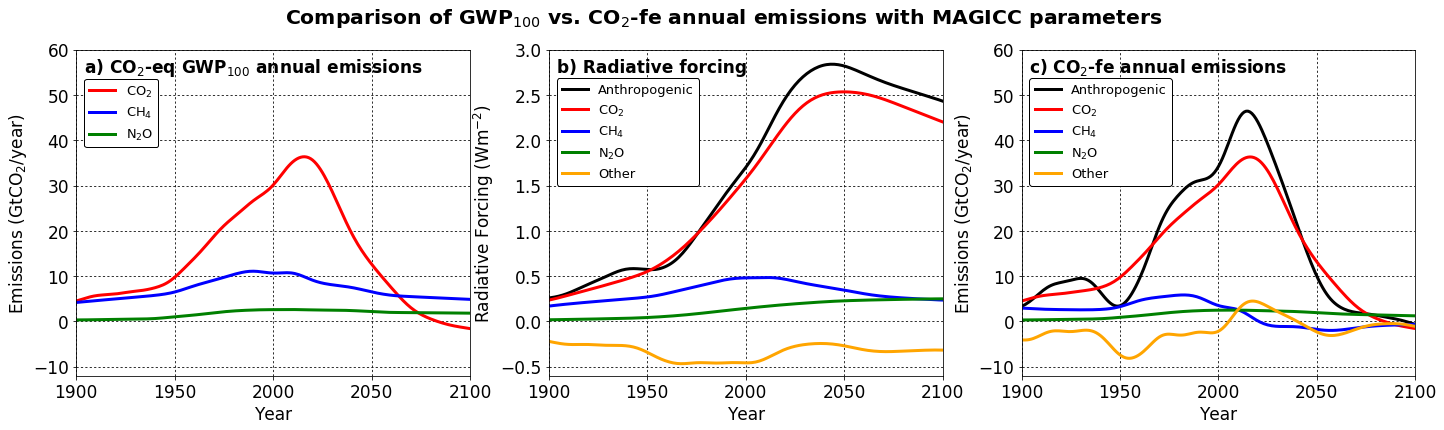

In [10]:
time = np.arange(1765,2501)

CO2_emissions = emissions * 44./12.
CH4_CO2_eq_GWP = M_emissions * 34./1000.
N2O_CO2_eq_GWP = N_emissions * 298./1000.

cum_CO2_fe = np.cumsum(CO2_CO2_fe_emms)
cum_CH4_fe = np.cumsum(CH4_CO2_fe_emms)
cum_N2O_fe = np.cumsum(N2O_CO2_fe_emms)
cum_anthro_fe = np.cumsum(anthro_CO2_fe_emms)
cum_other_fe = np.cumsum(other_CO2_fe_emms)

cum_anthro_fe_0 = np.cumsum(anthro_CO2_fe_emms_0)

# Smoothing

CO2_emissions_smooth = smooth(CO2_emissions,5)
CH4_CO2_eq_GWP_smooth = smooth(CH4_CO2_eq_GWP,5)
N2O_CO2_eq_GWP_smooth = smooth(N2O_CO2_eq_GWP,5)
cum_CO2_emms_GWP = np.cumsum(CO2_emissions_smooth)
cum_CH4_emms_GWP = np.cumsum(CH4_CO2_eq_GWP_smooth)
cum_N2O_emms_GWP = np.cumsum(N2O_CO2_eq_GWP_smooth)

fig = plt.figure(figsize=(24,6))
ax1 = fig.add_subplot(131)
ax3 = fig.add_subplot(133)
ax5 = fig.add_subplot(132)

ax1.grid(linestyle = ':',color = 'black')
ax1.text(1904,55,'a) CO$_2$-eq GWP$_{100}$ annual emissions', fontweight = 'bold')
ax1.plot(time,CO2_emissions_smooth,label='CO$_2$',color='red')
ax1.plot(time,CH4_CO2_eq_GWP_smooth,label='CH$_4$',color='blue')
ax1.plot(time,N2O_CO2_eq_GWP_smooth,label='N$_2$O',color='green')
ax1.set_ylabel('Emissions (GtCO$_2$/year)')
ax1.set_xlabel('Year')
ax1.legend(loc=(0.02,0.7),framealpha = 1,shadow = False,edgecolor = 'black',fontsize=13 )
ax1.set_xlim(1900,2100)
ax1.set_ylim(-12.,60.)

ax3.grid(linestyle = ':',color = 'black')
ax3.text(1904,55,'c) CO$_2$-fe annual emissions', fontweight = 'bold')
ax3.plot(time,anthro_CO2_fe_emms_0,label='Anthropogenic',color='black')
ax3.plot(time,CO2_CO2_fe_emms,label='CO$_2$',color='red')
ax3.plot(time,CH4_CO2_fe_emms,label='CH$_4$',color='blue')
ax3.plot(time,N2O_CO2_fe_emms,label='N$_2$O',color='green')
ax3.plot(time,other_CO2_fe_emms,label='Other',color='orange')
ax3.set_xlabel('Year')
ax3.set_ylabel('Emissions (GtCO$_2$/year)')
ax3.legend(loc=(0.02,0.583),framealpha = 1,shadow = False,edgecolor = 'black',fontsize=13 )
ax3.set_xlim(1900,2100)
ax3.set_ylim(-12.,60.)

ax5.grid(linestyle = ':',color = 'black')
ax5.text(1904,2.75,'b) Radiative forcing', fontweight = 'bold')
ax5.plot(time,ANTHRO_RF_0,label='Anthropogenic',color='black')
ax5.plot(time,CO2_RF,label='CO$_2$',color='red')
ax5.plot(time,CH4_RF,label='CH$_4$',color='blue')
ax5.plot(time,N2O_RF,label='N$_2$O',color='green')
ax5.plot(time,other_RF,label='Other',color='orange')
ax5.set_xlabel('Year')
ax5.set_ylabel('Radiative Forcing (Wm$^{-2}$)')
ax5.legend(loc=(0.02,0.583),framealpha = 1,shadow = False,edgecolor = 'black',fontsize=13 )
ax5.set_xlim(1900,2100)
ax5.set_ylim(-0.6,3.0)

#fig.suptitle('Comparison of GWP$_{100}$ vs. CO$_2$-fe annual emissions with MAGICC parameters', fontweight = 'bold')

#fig.savefig('./Figures/CO2-e vs CO2-fe Figure_MAGICC_params_adding.png',dpi=600)